# **Diversity report**

## **Completeness analysis**

Author: Daning Montaño - Ocampo

# **1. Packages and libraries**

In [179]:
library(dplyr)
library(ggplot2)
library(sf)
library(iNEXT)
library(tidyr)
library(vegan)
library(tibble)
library(ggspatial)
library(patchwork)

#library(doParallel)
#

# 2. Load clean data and grids

## 2.1. Records

In [180]:
species_records = read.csv("../Data/Records/species_records_clean.csv")

# Transform to sf object
species_records_sf = st_as_sf(species_records, coords = c("decimalLongitude", "decimalLatitude"), crs = 4326)
species_records_sf

Simple feature collection with 26187 features and 16 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -78.46784 ymin: -2.068253 xmax: -75.5828 ymax: 1.5
Geodetic CRS:  WGS 84
First 10 features:
   id_record database_name database_id occurrenceID basisOfRecord
1          1        BIOWEB   BIOWEB_45    QCA129294          <NA>
2          2        BIOWEB   BIOWEB_46    QCA129427          <NA>
3          3        BIOWEB   BIOWEB_49    QCA129514          <NA>
4          5        BIOWEB   BIOWEB_51    QCA129793          <NA>
5          8        BIOWEB   BIOWEB_54    QCA132457          <NA>
6          9        BIOWEB   BIOWEB_55     QCA13289          <NA>
7         10        BIOWEB   BIOWEB_57    QCA133934          <NA>
8         11        BIOWEB   BIOWEB_58     QCA13458          <NA>
9         12        BIOWEB   BIOWEB_59     QCA13492          <NA>
10        13        BIOWEB   BIOWEB_60     QCA13534          <NA>
   verbatimEventDate   recordedBy year institutionCode taxonRa

## 2.2. Arajuno polygon

In [181]:
arajuno_poly = st_read("../Data/SHP/Arajuno.shp")



Reading layer `Arajuno' from data source 
  `C:\PACHAMAMA\CONSERVACION\BIODIVERSIDAD ARAJUNO\ArajunoBiodiversity\Data\SHP\Arajuno.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -77.8054 ymin: -1.703907 xmax: -75.58041 ymax: -1.003981
Geodetic CRS:  WGS 84


## 2.3. Hexagons 10 km

In [182]:
grid_10km = st_read("../Data/SHP/HEXAGON_10_KM.shp")
grid_10km$id_10km = grid_10km$id
grid_10km = grid_10km %>% select(-id)

Reading layer `HEXAGON_10_KM' from data source 
  `C:\PACHAMAMA\CONSERVACION\BIODIVERSIDAD ARAJUNO\ArajunoBiodiversity\Data\SHP\HEXAGON_10_KM.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 928 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -77.80573 ymin: -1.749935 xmax: -75.54047 ymax: -1.001861
Geodetic CRS:  WGS 84


Cut Hexagons using Arajuno poly

In [183]:
grid_10km_cut = st_intersection(grid_10km, arajuno_poly)

Warning message:
attribute variables are assumed to be spatially constant throughout all geometries 


# 3. Join points to grids

In [184]:
recors_grid_10km <- st_join(
  species_records_sf,
  grid_10km_cut,
  join = st_within                              # inside polygons
)

# 4. Records and Sp per 10 km grid

## 4.1. All Taxas

We calculate the number of records per 10 km grid usind id_10km

In [185]:
total_grid = recors_grid_10km %>%
  as.data.frame() %>%
  group_by(id_10km)%>%
  summarise(Total_records = n()) %>%
  as.data.frame()

sp_grid = recors_grid_10km %>%
  as.data.frame() %>%
  group_by(id_10km)%>%
  distinct(scientificName) %>%
  summarise(Total_sp = n()) %>%
  as.data.frame()%>%
  mutate(Group = "All")

total_records_grid = total_grid %>% left_join(sp_grid, "id_10km")


## 4.2. Records per taxa

Create new categories

In [186]:
recors_grid_10km <- recors_grid_10km %>% 
  mutate(group = case_when(
    # Plants (vascular + non-vascular)
    class %in% c("Magnoliopsida", "Liliopsida",
                 "Lycopodiopsida", "Polypodiopsida",
                 "Bryopsida", "Jungermanniopsida",
                 "Gnetopsida", "Cycadopsida") ~ "Plants",

    # Birds
    class == "Aves" ~ "Birds",

    # Mammals
    class == "Mammalia" ~ "Mammals",

    # Arthropods + other invertebrates similar
    class %in% c("Insecta", "Arachnida", "Chilopoda",
                 "Malacostraca", "Gastropoda", "Bivalvia",
                 "Ostracoda") ~ "Arthropods",

    # Amphibians
    class == "Amphibia" ~ "Amphibians",

    # Reptiles
    class == "Reptilia" ~ "Reptiles",

    # Fungi
    class %in% c("Agaricomycetes", "Pezizomycetes",
                 "Sordariomycetes", "Tremellomycetes") ~ "Fungi",

    # Fish classes (separados si es necesario)
    class %in% c("Actinopterygii", "Elasmobranchii") ~ "Fish",

    # Everything else
    TRUE ~ "Others"
  ))
  records_x_taxa = recors_grid_10km %>%
    as.data.frame()%>%
    group_by(group)%>%
    summarise(Records = n())%>%
    arrange(-Records)
  
  records_x_taxa

# A tibble: 9 × 2
  group      Records
  <chr>        <int>
1 Plants       11593
2 Birds         8442
3 Mammals       2156
4 Amphibians    2080
5 Reptiles      1124
6 Arthropods     577
7 Fish           174
8 Fungi           32
9 Others           9

Records and species per taxa

In [187]:
taxas = unique(recors_grid_10km$group)


results_taxa_per_grid = data.frame(
  id_10km = numeric(0),
  Total_records = numeric(0),
  Total_sp = numeric(0)
)


for (i in taxas) {

  ## taxa print
  cat("Procces records and species", i, "\n")

  ## filter
  taxa_records = recors_grid_10km %>%
    filter(group == i) %>%
    group_by(id_10km) %>%
    summarise(Total_records = n()) %>%
    as.data.frame() %>%
    select(id_10km, Total_records)

  taxa_sp = recors_grid_10km %>%
    filter(group == i) %>%
    group_by(id_10km) %>%
    distinct(scientificName) %>%
    summarise(Total_sp = n()) %>%
    as.data.frame() %>%
    select(id_10km, Total_sp) %>%
    mutate(Group = i)

  results_taxa = taxa_records %>% 
    left_join(taxa_sp, "id_10km") %>% 
    as.data.frame()
  
  results_taxa_per_grid = rbind(results_taxa_per_grid, results_taxa)

  cat("- - - - - - - - - - - - - - - - - - - - -\n")

}

Procces records and species Plants 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Amphibians 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Arthropods 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Mammals 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Birds 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Reptiles 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Others 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Fish 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Fungi 
- - - - - - - - - - - - - - - - - - - - -


## 4.3. Join data per grid

In [188]:

results_taxa_total= rbind( results_taxa_per_grid, total_records_grid)


Example Map

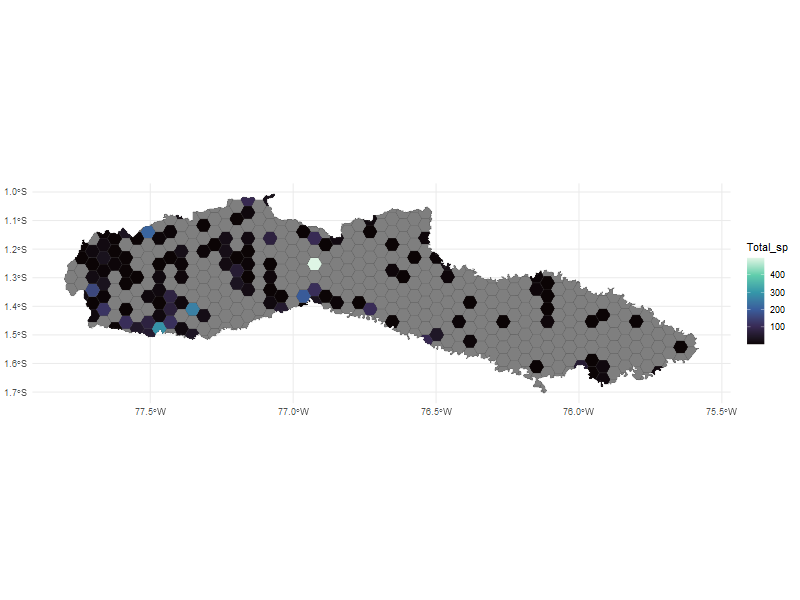

In [189]:

taxa_filter_records_per_grid = results_taxa_total%>% 
  filter(Group == "Plants")


grid_10km_cut%>% 
left_join(taxa_filter_records_per_grid, by = "id_10km")%>% 
  ggplot() +
    geom_sf(aes(fill = Total_sp), color = "grey30", size = 0.1) +
    scale_fill_viridis_c(option = "mako") +
    theme_minimal()

# 5. Sampling Completness

Calculate completnes for all Arajuno using incidens data and each 10 km cell is a unit. We conduce the analysis per taxa

Use iNEXT funtion to calculate the sampling coverage in Arajuno, an only extract richness (q=0) and sampling coverage

Call functions

In [190]:
source("../Functions/run_iNEXT_incidence_taxon.R")
source("../Functions/run_SC_abundance_taxon.R")
source("../Functions/compute_hex_metrics.R")


Custom Theme

In [191]:

color_hoja <- "#183D1E"   # Verde oscuro oficial Fundación Pachamama
color_hoja_light <- "#A9DFBF"  # Verde claro neutro complementario (no oficial pero compatible)

custom_theme_fp <- theme_minimal(base_size = 21) +
  theme(
    plot.title = element_text(size = 23, color = color_hoja),
    axis.title = element_text(size = 20, color = "black"),
    axis.text = element_text(size = 19, color = "black"),
    panel.grid.major = element_line(color = "#D6D8D9", linewidth = 0.3),
    panel.grid.minor = element_blank(),
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text = element_text(size = 19),
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )

  custom_theme_fp_map <- theme_minimal(base_size = 20) +
    theme(
      plot.title = element_text(size = 23, color = color_hoja),
      axis.title = element_text(size = 20),
      axis.text = element_text(size = 18),
      panel.grid = element_blank(),
      legend.position = "right",
      legend.title = element_text(size = 20, color = color_hoja),
      legend.text = element_text(size = 18)
    )
  


Plots and maps

In [192]:
make_inext_plot <- function(res_obj, type, title, ylab) {
  ggiNEXT(res_obj, type = type) +
    scale_color_manual(values = color_hoja) +
    scale_fill_manual(values = adjustcolor(color_hoja, alpha.f = 0.35)) +
    labs(
      title = title,
      x     = "Unidades de muestreo",
      y     = ylab
    ) +
    custom_theme_fp
}


make_hex_map <- function(data_sf, fill_var, fill_name, title) {
  ggplot(data_sf) +
    geom_sf(aes(fill = !!sym(fill_var)), color = "grey30", linewidth = 0.10) +
    scale_fill_gradient(
      name = fill_name,
      low  = color_hoja_light,
      high = color_hoja
    ) +
    labs(title = title) +
    custom_theme_fp_map +
    annotation_scale(location = "bl", width_hint = 0.25) +
    annotation_north_arrow(
      location   = "tl",
      which_north = "true",
      style      = north_arrow_fancy_orienteering(
        fill     = color_hoja,
        line_col = color_hoja
      ),
      height = unit(1.2, "cm"),
      width  = unit(1.2, "cm")
    )
}

## 5.1. Birds

### Using All area

In [193]:
res_birds <- run_iNEXT_incidence_taxon(
  taxon_name = "Birds",
  min_records = 10,
  nboot = 100
)


Celdas filtradas: 54 
Registros encontrados: 7253 
Especies: 483 | Celdas: 54 
SC: 0.9514 | Sp_obs: 483 | Units_obs: 54 | Units_ext: 108 | Sp_ext: 564.116 


### Analysis per hexagon

In [194]:
hex_birds <- run_SC_abundance_taxon(
  taxon_name = "Birds",
  min_records = 10,
  nboot = 200
)



Celdas filtradas: 54 
Registros encontrados: 7253 
  |======================================================================| 100%


Warning message:
In EstiBootComm.Ind(x[[i]]) :
  This site has only one species. Estimation is not robust.


### Birds Report

Export plots

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


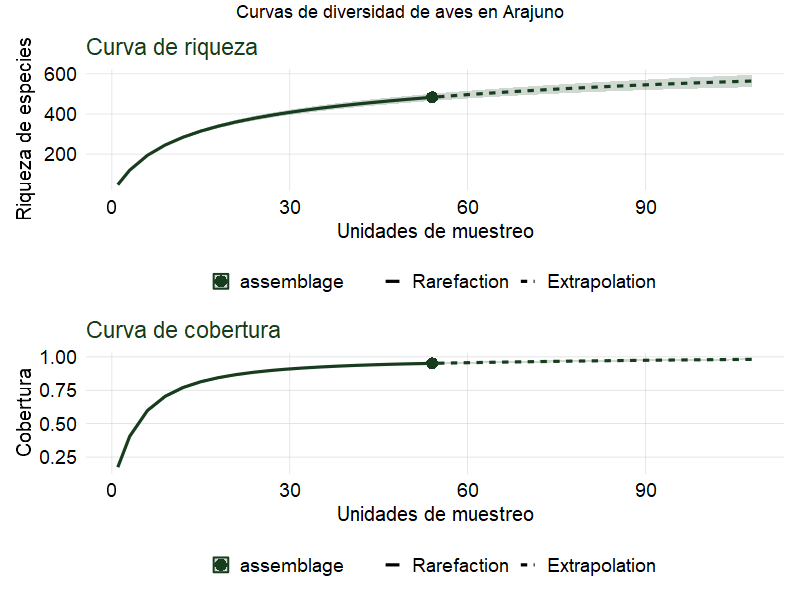

In [195]:
# Curva de cobertura
plot_units_coverage_birds <- make_inext_plot(
  res_obj = res_birds$result,
  type    = 1,
  title   = "Curva de riqueza",
  ylab    = "Riqueza de especies"

)

# Curva de riqueza
plot_units_sp_birds <- make_inext_plot(
  res_obj = res_birds$result,
  type    = 2,
  title   = "Curva de cobertura",
  ylab    = "Cobertura"
)
# Curvas pequeñas (derecha)
curves_birds <- plot_units_coverage_birds /
             plot_units_sp_birds
curves_birds = curves_birds+
  plot_annotation(
    title = "Curvas de diversidad de aves en Arajuno",
    theme = theme(
      plot.title = element_text(
        hjust = 0.5,        # << CENTRADO
        size = 18,
        face = "plain"
      )
    )
  )
  curves_birds


In [196]:
ggsave(
  filename = "../Results/Reports/Birds/aves_curves.png",
  plot     = curves_birds,
  width    = 9,
  height   = 9,
  dpi      = 300
)

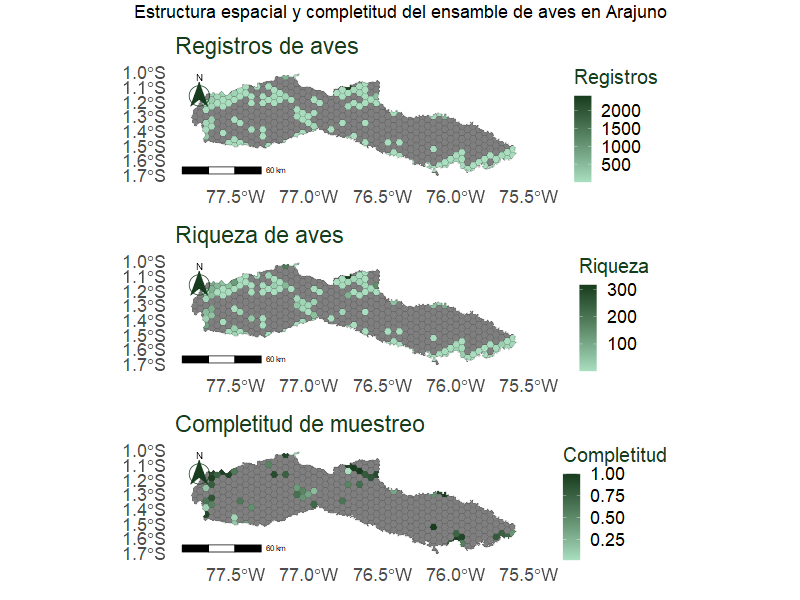

In [197]:
#-----------------------------------------
# Datos base para mapas (registros y spp)
#-----------------------------------------
taxa_filter_records_per_grid <- results_taxa_total %>%
  filter(Group == "Birds")

birds_grid <- grid_10km_cut %>%
  left_join(taxa_filter_records_per_grid, by = "id_10km")


# Mapa: registros
map_birds_records <- make_hex_map(
  data_sf   = birds_grid,
  fill_var  = "Total_records",
  fill_name = "Registros",
  title     = "Registros de aves"
)

# Mapa: riqueza
map_birds_sp <- make_hex_map(
  data_sf   = birds_grid,
  fill_var  = "Total_sp",
  fill_name = "Riqueza",
  title     = "Riqueza de aves"
)

# Mapa: completitud (usa hex_birds directamente)
map_birds_sc <- make_hex_map(
  data_sf   = hex_birds,
  fill_var  = "Sampling_coverage",
  fill_name = "Completitud",
  title     = "Completitud de muestreo"
)

maps_grid_birds <- (map_birds_records /
  map_birds_sp /
  map_birds_sc) +
plot_annotation(
title = "Estructura espacial y completitud del ensamble de aves en Arajuno",
theme = theme(
plot.title = element_text(
hjust = 0.5,
size  = 18,
face  = "plain"
)
)
)

maps_grid_birds

In [198]:
ggsave(
  filename = "../Results/Reports/Birds/mapas_aves.png",
  plot     = maps_grid_birds,
  width    = 14,
  height   = 18,
  dpi      = 300
)

Export spatial analysis

In [199]:
hex_birds_full <- grid_10km_cut %>% 
  left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  left_join(
    hex_birds %>% st_drop_geometry() %>% select(id_10km, Sampling_coverage),
    by = "id_10km"
  )
  metrics_birds <- compute_hex_metrics(
    hex_sf       = hex_birds_full,
    records_col  = "Total_records",
    richness_col = "Total_sp",
    coverage_col = "Sampling_coverage",
    majority_prop = 0.8   # mayoría = 80% de los registros
  )
  
write.csv(metrics_birds, "../Results/Reports/Birds/aves_spatial_metrics.csv")

Export metrics

In [200]:
write.csv(res_birds$metrics, "../Results/Reports/Birds/aves_metrics.csv")

Export shapes

In [201]:
hex_birds_full <- grid_10km_cut %>% 
  left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  left_join(
    hex_birds %>% st_drop_geometry() %>% select(id_10km, Sampling_coverage),
    by = "id_10km"
  )

  st_write(
    hex_birds_full,
    "../Results/Reports/Birds/aves_shp/Aves_hexagonos_metricas.shp",
    delete_layer = TRUE
  )
  

Writing layer `Aves_hexagonos_metricas' to data source 
  `../Results/Reports/Birds/aves_shp/Aves_hexagonos_metricas.shp' using driver `ESRI Shapefile'
Writing 498 features with 15 fields and geometry type Unknown (any).


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver


## 5.2. Plants

### Using All area

In [202]:
res_plants <- run_iNEXT_incidence_taxon(
  taxon_name = "Plants",
  min_records = 10,
  nboot = 100
)


Celdas filtradas: 56 
Registros encontrados: 9513 
Especies: 1808 | Celdas: 56 
SC: 0.7086 | Sp_obs: 1808 | Units_obs: 56 | Units_ext: 112 | Sp_ext: 2564.331 


### Analysis per hexagon

In [203]:
hex_plants <- run_SC_abundance_taxon(
  taxon_name = "Plants",
  min_records = 10,
  nboot = 200
)


Celdas filtradas: 56 
Registros encontrados: 9513 
  |======================================================================| 100%


### Plants Report

Export plots

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


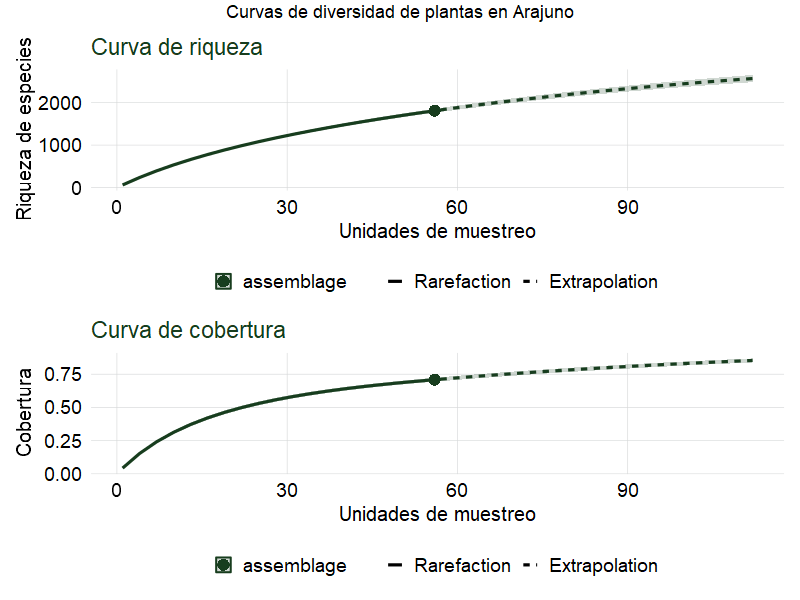

In [204]:
# Curva de cobertura
plot_units_coverage_plants<- make_inext_plot(
  res_obj = res_plants$result,
  type    = 1,
  title   = "Curva de riqueza",
  ylab    = "Riqueza de especies"
)

# Curva de riqueza
plot_units_sp_plants <- make_inext_plot(
  res_obj = res_plants$result,
  type    = 2,
  title   = "Curva de cobertura",
  ylab    = "Cobertura"
)
# Curvas pequeñas (derecha)
curves_plants <- plot_units_coverage_plants /
  plot_units_sp_plants
curves_plants = curves_plants+
  plot_annotation(
    title = "Curvas de diversidad de plantas en Arajuno",
    theme = theme(
      plot.title = element_text(
        hjust = 0.5,        # << CENTRADO
        size = 18,
        face = "plain"
      )
    )
  )
  curves_plants

In [205]:
ggsave(
  filename = "../Results/Reports/Plants/plantas_curves.png",
  plot     = curves_plants,
  width    = 9,
  height   = 9,
  dpi      = 300
)

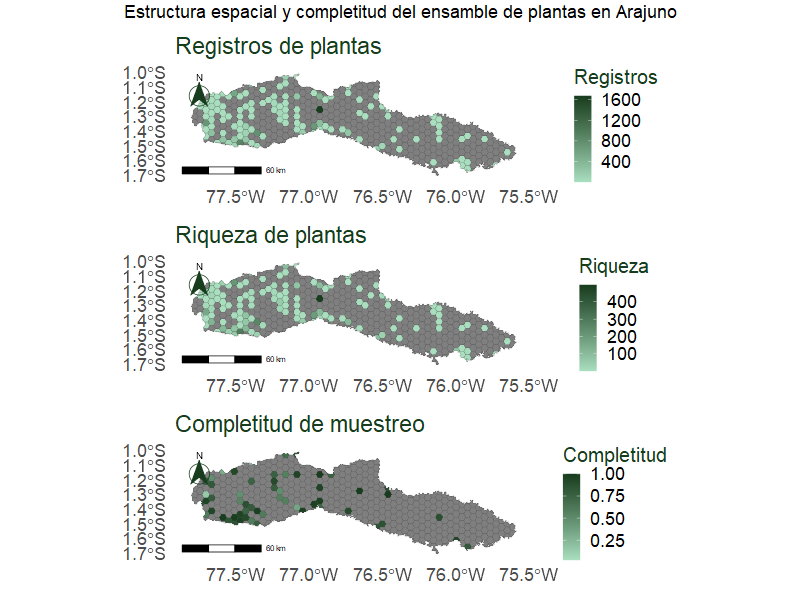

In [206]:
#-----------------------------------------
# Datos base para mapas (registros y spp)
#-----------------------------------------
taxa_filter_records_per_grid <- results_taxa_total %>%
  filter(Group == "Plants")

plants_grid <- grid_10km_cut %>%
  left_join(taxa_filter_records_per_grid, by = "id_10km")


# Mapa: registros
map_plants_records <- make_hex_map(
  data_sf   = plants_grid,
  fill_var  = "Total_records",
  fill_name = "Registros",
  title     = "Registros de plantas"
)

# Mapa: riqueza
map_plants_sp <- make_hex_map(
  data_sf   = plants_grid,
  fill_var  = "Total_sp",
  fill_name = "Riqueza",
  title     = "Riqueza de plantas"
)

# Mapa: completitud (usa hex_birds directamente)
map_plants_sc <- make_hex_map(
  data_sf   = hex_plants,
  fill_var  = "Sampling_coverage",
  fill_name = "Completitud",
  title     = "Completitud de muestreo"
)

maps_grid_plants <- (map_plants_records /
  map_plants_sp /
    map_plants_sc) +
plot_annotation(
title = "Estructura espacial y completitud del ensamble de plantas en Arajuno",
theme = theme(
plot.title = element_text(
hjust = 0.5,
size  = 18,
face  = "plain"
)
)
)

maps_grid_plants

In [207]:
ggsave(
  filename = "../Results/Reports/Plants/mapas_plantas.png",
  plot     = maps_grid_plants,
  width    = 14,
  height   = 18,
  dpi      = 300
)

Export spatial analysis

In [208]:
hex_plants_full <- grid_10km_cut %>% 
  left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  left_join(
    hex_plants %>% st_drop_geometry() %>% select(id_10km, Sampling_coverage),
    by = "id_10km"
  )
  metrics_birds <- compute_hex_metrics(
    hex_sf       = hex_plants_full,
    records_col  = "Total_records",
    richness_col = "Total_sp",
    coverage_col = "Sampling_coverage",
    majority_prop = 0.8   # mayoría = 80% de los registros
  )
  
write.csv(metrics_birds, "../Results/Reports/Plants/plantas_spatial_metrics.csv")

Export metrics

In [209]:
write.csv(res_plants$metrics, "../Results/Reports/Plants/plantas_metrics.csv")

Expor Shp

In [210]:
hex_plants_full <- grid_10km_cut %>% 
  left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  left_join(
    hex_plants %>% st_drop_geometry() %>% select(id_10km, Sampling_coverage),
    by = "id_10km"
  )

  st_write(
    hex_birds_full,
    "../Results/Reports/Plants/plantas_shp/Plantas_hexagonos_metricas.shp",
    delete_layer = TRUE
  )

Writing layer `Plantas_hexagonos_metricas' to data source 
  `../Results/Reports/Plants/plantas_shp/Plantas_hexagonos_metricas.shp' using driver `ESRI Shapefile'
Writing 498 features with 15 fields and geometry type Unknown (any).


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver


 ## 5.3. Mammals

### Using All area

In [211]:
res_mammals <- run_iNEXT_incidence_taxon(
  taxon_name = "Mammals",
  min_records = 10,
  nboot = 100
)

Celdas filtradas: 25 
Registros encontrados: 1506 
Especies: 115 | Celdas: 25 
SC: 0.9116 | Sp_obs: 115 | Units_obs: 25 | Units_ext: 50 | Sp_ext: 137.6507 


### Analysis per hexagon

In [212]:
hex_mammals<- run_SC_abundance_taxon(
  taxon_name = "Mammals",
  min_records = 10,
  nboot = 200
)


Celdas filtradas: 25 
Registros encontrados: 1506 
  |======================================================================| 100%


Warning message:
In EstiBootComm.Ind(x[[i]]) :
  This site has only one species. Estimation is not robust.


### Mammals Report

Export plots

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


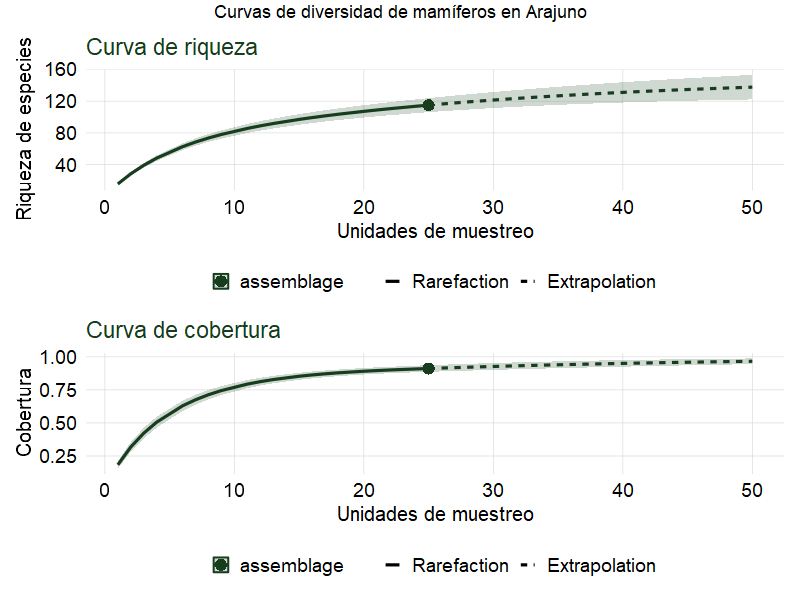

In [213]:
# Curva de cobertura
plot_units_coverage_mammals<- make_inext_plot(
  res_obj = res_mammals$result,
  type    = 1,
  title   = "Curva de riqueza",
  ylab    = "Riqueza de especies"
)

# Curva de riqueza
plot_units_sp_mammals <- make_inext_plot(
  res_obj = res_mammals$result,
  type    = 2,
  title   = "Curva de cobertura",
  ylab    = "Cobertura"
)
# Curvas pequeñas (derecha)
curves_mammals <- plot_units_coverage_mammals /
  plot_units_sp_mammals
curves_mammals = curves_mammals+
  plot_annotation(
    title = "Curvas de diversidad de mamíferos en Arajuno",
    theme = theme(
      plot.title = element_text(
        hjust = 0.5,        # << CENTRADO
        size = 18,
        face = "plain"
      )
    )
  )
  curves_mammals

In [214]:
ggsave(
  filename = "../Results/Reports/Mammals/mammals_curves.png",
  plot     = curves_mammals,
  width    = 9,
  height   = 9,
  dpi      = 300
)

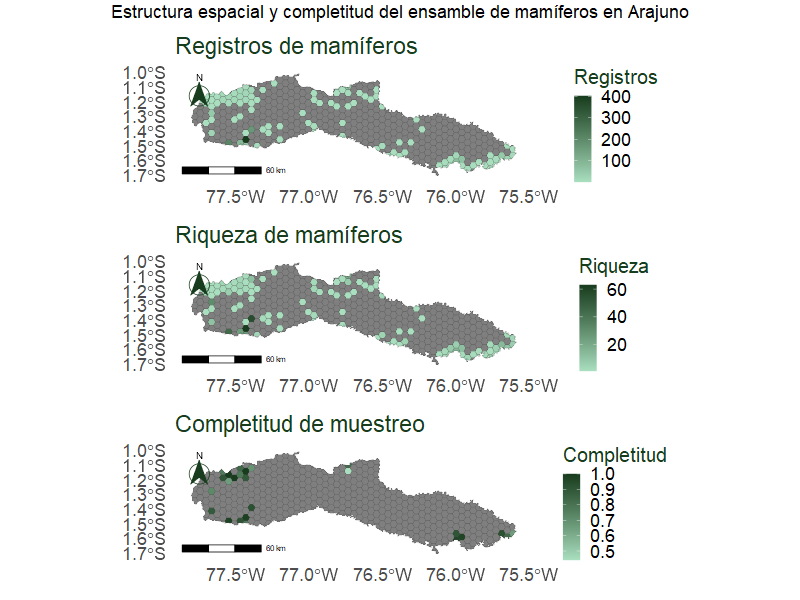

In [215]:
#-----------------------------------------
# Datos base para mapas (registros y spp)
#-----------------------------------------
taxa_filter_records_per_grid <- results_taxa_total %>%
  filter(Group == "Mammals")

mammals_grid <- grid_10km_cut %>%
  left_join(taxa_filter_records_per_grid, by = "id_10km")


# Mapa: registros
map_mammals_records <- make_hex_map(
  data_sf   = mammals_grid,
  fill_var  = "Total_records",
  fill_name = "Registros",
  title     = "Registros de mamíferos"
)

# Mapa: riqueza
map_mammals_sp <- make_hex_map(
  data_sf   = mammals_grid,
  fill_var  = "Total_sp",
  fill_name = "Riqueza",
  title     = "Riqueza de mamíferos"
)

# Mapa: completitud (usa hex_birds directamente)
map_mammals_sc <- make_hex_map(
  data_sf   = hex_mammals,
  fill_var  = "Sampling_coverage",
  fill_name = "Completitud",
  title     = "Completitud de muestreo"
)

maps_grid_mammals <- (map_mammals_records /
  map_mammals_sp /
    map_mammals_sc) +
plot_annotation(
title = "Estructura espacial y completitud del ensamble de mamíferos en Arajuno",
theme = theme(
plot.title = element_text(
hjust = 0.5,
size  = 18,
face  = "plain"
)
)
)

maps_grid_mammals

In [216]:
ggsave(
  filename = "../Results/Reports/Mammals/mapas_mamiferos.png",
  plot     = maps_grid_mammals,
  width    = 14,
  height   = 18,
  dpi      = 300
)

Export spatial analysis

In [217]:
hex_mammals_full <- grid_10km_cut %>% 
  left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  left_join(
    hex_mammals%>% st_drop_geometry() %>% select(id_10km, Sampling_coverage),
    by = "id_10km"
  )
  metrics_mammals <- compute_hex_metrics(
    hex_sf       = hex_mammals_full,
    records_col  = "Total_records",
    richness_col = "Total_sp",
    coverage_col = "Sampling_coverage",
    majority_prop = 0.8   # mayoría = 80% de los registros
  )
  
write.csv(metrics_mammals, "../Results/Reports/Mammals/mamiferos_spatial_metrics.csv")

Export metrixcs

In [218]:
write.csv(res_mammals$metrics, "../Results/Reports/Mammals/mamiferos_metrics.csv")

Export Shp

In [219]:
hex_mammals_full <- grid_10km_cut %>% 
  left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  left_join(
    hex_mammals %>% st_drop_geometry() %>% select(id_10km, Sampling_coverage),
    by = "id_10km"
  )

  st_write(
    hex_mammals,
    "../Results/Reports/Mammals/mamiferos_shp/Mamiferos_hexagonos_metricas.shp",
    delete_layer = TRUE
  )

Writing layer `Mamiferos_hexagonos_metricas' to data source 
  `../Results/Reports/Mammals/mamiferos_shp/Mamiferos_hexagonos_metricas.shp' using driver `ESRI Shapefile'
Writing 498 features with 12 fields and geometry type Unknown (any).


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver


## 5.4. Amphibia

### Using All area

In [220]:
res_amphibians<- run_iNEXT_incidence_taxon(
  taxon_name = "Amphibians",
  min_records = 10,
  nboot = 100
)

Celdas filtradas: 25 
Registros encontrados: 1457 
Especies: 126 | Celdas: 25 
SC: 0.946 | Sp_obs: 126 | Units_obs: 25 | Units_ext: 50 | Sp_ext: 142.0098 


### Analysis per hexagon

In [221]:
hex_amphibians<- run_SC_abundance_taxon(
  taxon_name = "Amphibians",
  min_records = 10,
  nboot = 200
)


Celdas filtradas: 25 
Registros encontrados: 1457 
  |======================================================================| 100%


### Amphibians report

Export Plots

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


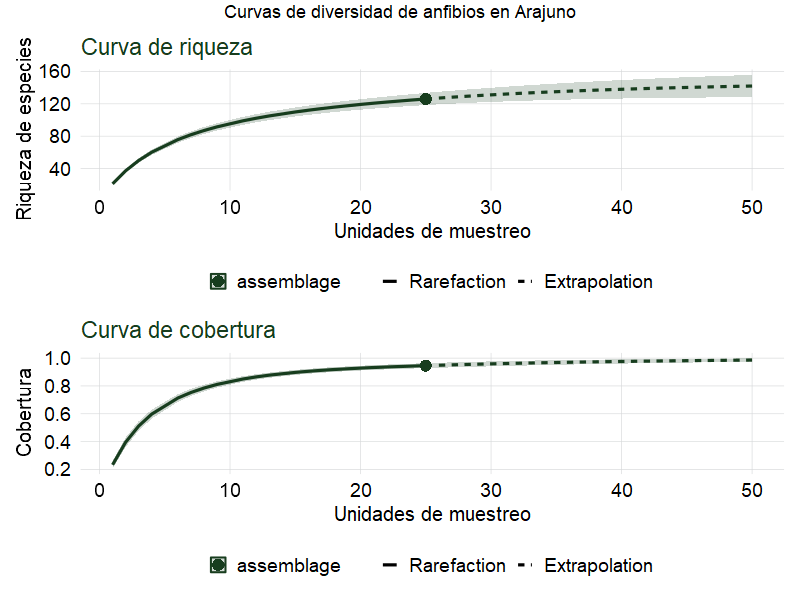

In [222]:
# Curva de cobertura
plot_units_coverage_amphibians <- make_inext_plot(
  res_obj = res_amphibians$result,
  type    = 1,
  title   = "Curva de riqueza",
  ylab    = "Riqueza de especies"
)

# Curva de riqueza
plot_units_sp_amphibians <- make_inext_plot(
  res_obj = res_amphibians$result,
  type    = 2,
  title   = "Curva de cobertura",
  ylab    = "Cobertura"
)

# Curvas pequeñas (derecha)
curves_amphibians <- plot_units_coverage_amphibians /
  plot_units_sp_amphibians

curves_amphibians <- curves_amphibians +
  patchwork::plot_annotation(
    title = "Curvas de diversidad de anfibios en Arajuno",
    theme = theme(
      plot.title = element_text(
        hjust = 0.5,
        size  = 18,
        face  = "plain"
      )
    )
  )

curves_amphibians


In [223]:
ggsave(
  filename = "../Results/Reports/Amphibians/Amphibians_curves.png",
  plot     = curves_amphibians,
  width    = 9,
  height   = 9,
  dpi      = 300
)

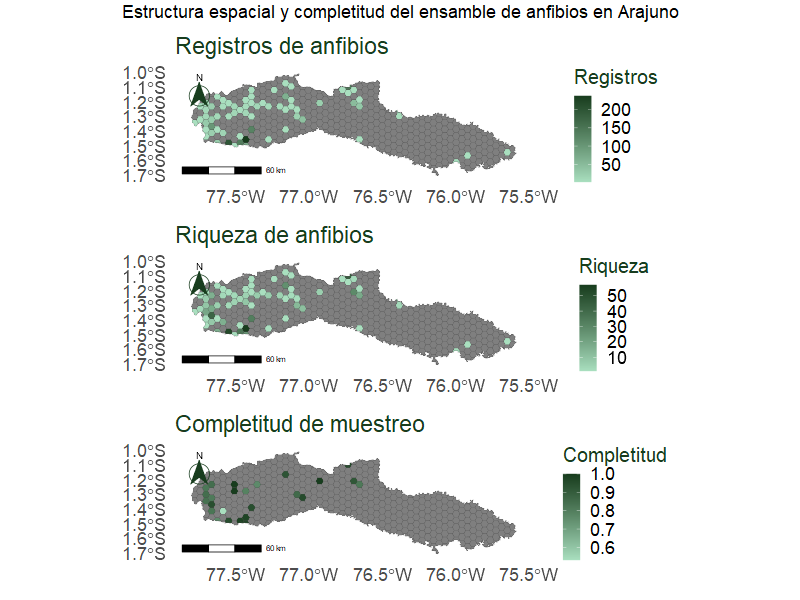

In [224]:
#-----------------------------------------
# Datos base para mapas (registros y spp)
#-----------------------------------------
taxa_filter_records_per_grid <- results_taxa_total %>%
  dplyr::filter(Group == "Amphibians")

amphibians_grid <- grid_10km_cut %>%
  dplyr::left_join(taxa_filter_records_per_grid, by = "id_10km")

#-----------------------------------------
# Mapa: registros
#-----------------------------------------
map_amphibians_records <- make_hex_map(
  data_sf   = amphibians_grid,
  fill_var  = "Total_records",
  fill_name = "Registros",
  title     = "Registros de anfibios"
)

#-----------------------------------------
# Mapa: riqueza
#-----------------------------------------
map_amphibians_sp <- make_hex_map(
  data_sf   = amphibians_grid,
  fill_var  = "Total_sp",
  fill_name = "Riqueza",
  title     = "Riqueza de anfibios"
)

#-----------------------------------------
# Mapa: completitud
#   (asumiendo que ya generaste hex_amphibians con run_SC_abundance_taxon())
#-----------------------------------------
map_amphibians_sc <- make_hex_map(
  data_sf   = hex_amphibians,
  fill_var  = "Sampling_coverage",
  fill_name = "Completitud",
  title     = "Completitud de muestreo"
)

#-----------------------------------------
# Ensamble final de mapas
#-----------------------------------------
maps_grid_amphibians <- (
  map_amphibians_records /
  map_amphibians_sp /
  map_amphibians_sc
) +
  patchwork::plot_annotation(
    title = "Estructura espacial y completitud del ensamble de anfibios en Arajuno",
    theme = theme(
      plot.title = element_text(
        hjust = 0.5,
        size  = 18,
        face  = "plain"
      )
    )
  )

maps_grid_amphibians


In [225]:
ggsave(
  filename = "../Results/Reports/Amphibians/mapas_anfibios.png",
  plot     = maps_grid_amphibians,
  width    = 14,
  height   = 18,
  dpi      = 300
)

Expor Spatial Analysys

In [226]:
hex_amphibians_full <- grid_10km_cut %>% 
  dplyr::left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  dplyr::left_join(
    hex_amphibians %>% 
      sf::st_drop_geometry() %>% 
      dplyr::select(id_10km, Sampling_coverage),
    by = "id_10km"
  )

metrics_amphibians <- compute_hex_metrics(
  hex_sf        = hex_amphibians_full,
  records_col   = "Total_records",
  richness_col  = "Total_sp",
  coverage_col  = "Sampling_coverage",
  majority_prop = 0.8
)

write.csv(
  metrics_amphibians,
  "../Results/Reports/Amphibians/anfibios_spatial_metrics.csv",
  row.names = FALSE
)


Export metrics

In [227]:
write.csv(res_amphibians$metrics, "../Results/Reports/Amphibians/anfibios_metrics.csv")

Export shp

In [228]:
hex_amphibians_full <- grid_10km_cut %>% 
  dplyr::left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  dplyr::left_join(
    hex_amphibians %>%
      sf::st_drop_geometry() %>%
      dplyr::select(id_10km, Sampling_coverage),
    by = "id_10km"
  )

sf::st_write(
  hex_amphibians,
  "../Results/Reports/Amphibians/anfibios_shp/Anfibios_hexagonos_metricas.shp",
  delete_layer = TRUE
)

Writing layer `Anfibios_hexagonos_metricas' to data source 
  `../Results/Reports/Amphibians/anfibios_shp/Anfibios_hexagonos_metricas.shp' using driver `ESRI Shapefile'
Writing 498 features with 12 fields and geometry type Unknown (any).


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver


## 5.5. Reptiles

### Using All area

In [234]:
res_reptiles <- run_iNEXT_incidence_taxon(
  taxon_name = "Reptiles",
  min_records = 10,
  nboot = 100
)

Celdas filtradas: 19 
Registros encontrados: 721 
Especies: 106 | Celdas: 19 
SC: 0.8977 | Sp_obs: 106 | Units_obs: 19 | Units_ext: 38 | Sp_ext: 130.2283 


### Analysis per hexagon

In [235]:
hex_reptiles<- run_SC_abundance_taxon(
  taxon_name = "Reptiles",
  min_records = 10,
  nboot = 200
)

Celdas filtradas: 19 
Registros encontrados: 721 
  |======================================================================| 100%


Warning message:
In EstiBootComm.Ind(x[[i]]) :
  This site has only one species. Estimation is not robust.


### Reptiles report

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


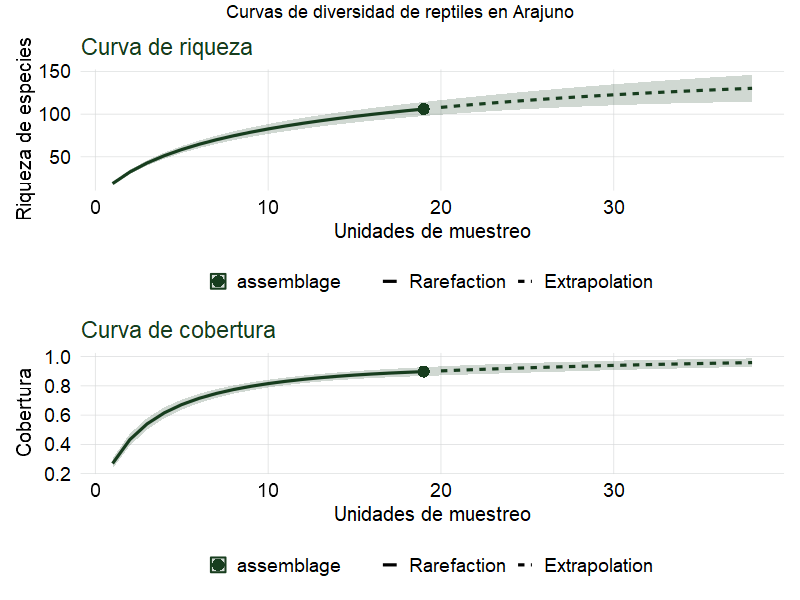

In [236]:
# Curva de cobertura
plot_units_coverage_reptiles <- make_inext_plot(
  res_obj = res_reptiles$result,
  type    = 1,
  title   = "Curva de riqueza",
  ylab    = "Riqueza de especies"
)

# Curva de riqueza
plot_units_sp_reptiles <- make_inext_plot(
  res_obj = res_reptiles$result,
  type    = 2,
  title   = "Curva de cobertura",
  ylab    = "Cobertura"
)

# Curvas pequeñas (derecha)
curves_reptiles <- plot_units_coverage_reptiles /
  plot_units_sp_reptiles

curves_reptiles <- curves_reptiles +
  patchwork::plot_annotation(
    title = "Curvas de diversidad de reptiles en Arajuno",
    theme = theme(
      plot.title = element_text(
        hjust = 0.5,
        size  = 18,
        face  = "plain"
      )
    )
  )

curves_reptiles


In [237]:
ggsave(
  filename = "../Results/Reports/Reptiles/Reptiles_curves.png",
  plot     = curves_reptiles,
  width    = 9,
  height   = 9,
  dpi      = 300
)

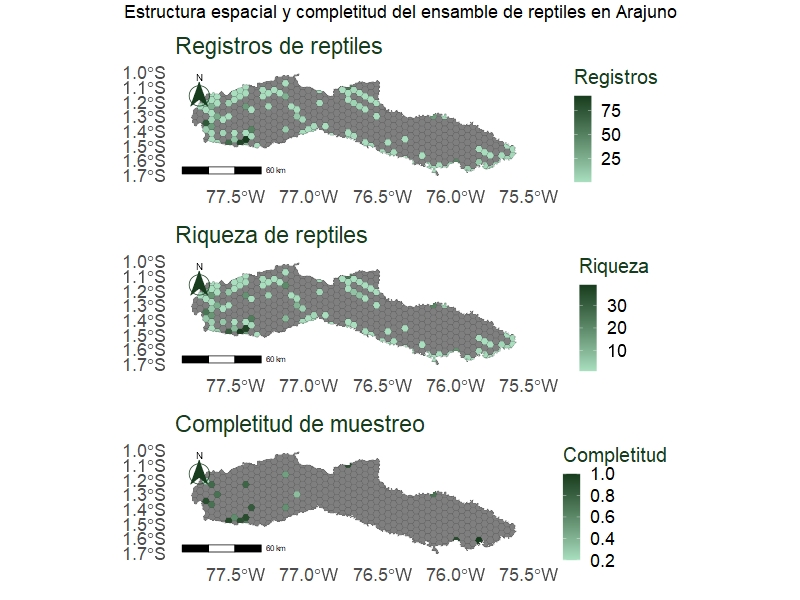

In [238]:
#-----------------------------------------
# Datos base para mapas (registros y spp)
#-----------------------------------------
taxa_filter_records_per_grid <- results_taxa_total %>%
  dplyr::filter(Group == "Reptiles")

reptiles_grid <- grid_10km_cut %>%
  dplyr::left_join(taxa_filter_records_per_grid, by = "id_10km")

#-----------------------------------------
# Mapa: registros
#-----------------------------------------
map_reptiles_records <- make_hex_map(
  data_sf   = reptiles_grid,
  fill_var  = "Total_records",
  fill_name = "Registros",
  title     = "Registros de reptiles"
)

#-----------------------------------------
# Mapa: riqueza
#-----------------------------------------
map_reptiles_sp <- make_hex_map(
  data_sf   = reptiles_grid,
  fill_var  = "Total_sp",
  fill_name = "Riqueza",
  title     = "Riqueza de reptiles"
)

#-----------------------------------------
# Mapa: completitud
# (usa hex_reptiles generado con run_SC_abundance_taxon)
#-----------------------------------------
map_reptiles_sc <- make_hex_map(
  data_sf   = hex_reptiles,
  fill_var  = "Sampling_coverage",
  fill_name = "Completitud",
  title     = "Completitud de muestreo"
)

#-----------------------------------------
# Ensamble final de mapas
#-----------------------------------------
maps_grid_reptiles <- (
  map_reptiles_records /
  map_reptiles_sp /
  map_reptiles_sc
) +
  patchwork::plot_annotation(
    title = "Estructura espacial y completitud del ensamble de reptiles en Arajuno",
    theme = theme(
      plot.title = element_text(
        hjust = 0.5,
        size  = 18,
        face  = "plain"
      )
    )
  )

maps_grid_reptiles


In [239]:
ggsave(
  filename = "../Results/Reports/Reptiles/mapas_reptiles.png",
  plot     = maps_grid_reptiles,
  width    = 14,
  height   = 18,
  dpi      = 300
)

In [240]:
hex_reptiles_full <- grid_10km_cut %>% 
  dplyr::left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  dplyr::left_join(
    hex_reptiles %>% 
      sf::st_drop_geometry() %>% 
      dplyr::select(id_10km, Sampling_coverage),
    by = "id_10km"
  )

metrics_reptiles <- compute_hex_metrics(
  hex_sf        = hex_reptiles_full,
  records_col   = "Total_records",
  richness_col  = "Total_sp",
  coverage_col  = "Sampling_coverage",
  majority_prop = 0.8
)

write.csv(
  metrics_reptiles,
  "../Results/Reports/Reptiles/reptiles_spatial_metrics.csv",
  row.names = FALSE
)


In [242]:
write.csv(res_reptiles$metrics, "../Results/Reports/Amphibians/reptiles_metrics.csv")

In [243]:
hex_reptiles_full <- grid_10km_cut %>% 
  dplyr::left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  dplyr::left_join(
    hex_reptiles %>%
      sf::st_drop_geometry() %>%
      dplyr::select(id_10km, Sampling_coverage),
    by = "id_10km"
  )

sf::st_write(
  hex_reptiles,
  "../Results/Reports/Reptiles/reptiles_shp/Reptiles_hexagonos_metricas.shp",
  delete_layer = TRUE
)


Writing layer `Reptiles_hexagonos_metricas' to data source 
  `../Results/Reports/Reptiles/reptiles_shp/Reptiles_hexagonos_metricas.shp' using driver `ESRI Shapefile'
Writing 498 features with 12 fields and geometry type Unknown (any).


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver
